In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_log_error as rmsle
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor, Pool
import seaborn as sns
import itertools

In [2]:
train = pd.read_csv("train_comp.csv")
test = pd.read_csv("test_comp.csv")
# sample = pd.read_csv("sample_submission.csv")

train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,36,189,82,26,101,41.0,150
1,female,64,163,60,8,85,39.7,34
2,female,51,161,64,7,84,39.8,29
3,male,20,192,90,25,105,40.7,140
4,female,38,166,61,25,102,40.6,146


In [3]:
numerical_features = ["Age","Height","Weight","Duration","Heart_Rate","Body_Temp"]

def add_feats(df, numerical_features):
    ''''''''''
    Inputs: dataframe df
    Output: the modified dataframe with cross terms, BMI, id+calories removed, and sex as categorical variable
    '''''''''
    df_new = df.copy()

    features = df_new.columns

    if 'id' in features:
        df_new = df_new.drop(columns=['id'])
    
    if 'Calories' in features:
        df_new = df_new.drop(columns=['Calories'])
    
    
    df_new['Sex'] = df_new['Sex'].astype('category')

    df_new['BMI'] = df_new['Weight']/((df_new['Height']/100)**2)

    for i in range(len(numerical_features)):
        for j in range(i + 1, len(numerical_features)):  
            feature1 = numerical_features[i]
            feature2 = numerical_features[j]
            cross_term_name = f"{feature1}_x_{feature2}"
            df_new[cross_term_name] = df_new[feature1] * df_new[feature2]
            #cross_term_name = f"{feature1}_divided_{feature2}"
            #df_new[cross_term_name] = df_new[feature1] / df_new[feature2]

    return df_new

In [4]:
y = np.log1p(train['Calories'])

X = add_feats(train, numerical_features)

X.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Age_x_Height,Age_x_Weight,...,Height_x_Weight,Height_x_Duration,Height_x_Heart_Rate,Height_x_Body_Temp,Weight_x_Duration,Weight_x_Heart_Rate,Weight_x_Body_Temp,Duration_x_Heart_Rate,Duration_x_Body_Temp,Heart_Rate_x_Body_Temp
0,male,36,189,82,26,101,41.0,22.955684,6804,2952,...,15498,4914,19089,7749.0,2132,8282,3362.0,2626,1066.0,4141.0
1,female,64,163,60,8,85,39.7,22.582709,10432,3840,...,9780,1304,13855,6471.1,480,5100,2382.0,680,317.6,3374.5
2,female,51,161,64,7,84,39.8,24.690405,8211,3264,...,10304,1127,13524,6407.8,448,5376,2547.2,588,278.6,3343.2
3,male,20,192,90,25,105,40.7,24.414062,3840,1800,...,17280,4800,20160,7814.4,2250,9450,3663.0,2625,1017.5,4273.5
4,female,38,166,61,25,102,40.6,22.136740,6308,2318,...,10126,4150,16932,6739.6,1525,6222,2476.6,2550,1015.0,4141.2


In [26]:
iterations = [250, 350, 500]
learning_rate = [0.15, 0.1, 0.05]
max_depth = [8, 10]                   # 16 is the max
# subsamp = [0.8, 0.9, 1]

model_err = {}

for it, lr, md in itertools.product(iterations, learning_rate, max_depth):
    # Initialize KFold
    kf = KFold(n_splits=5, shuffle=True)

    # Initialize a list to collect accuracy scores
    scores = []

    # Iterate over each fold
    for train_index, test_index in kf.split(X):

        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        # dtrain = Pool(X_train, y_train, cat_features=[0])
                
        # Define parameters
        params = {
            'iterations': it,
            'learning_rate': lr,
            'depth': md,                 # max depth is 16
            'loss_function': 'RMSE',
            'eval_metric': 'RMSE',
            'early_stopping_rounds': 25,
            #'subsample': ss,
            'task_type': 'GPU',
            'verbose': -1
        }

        # Initialize and train the model
        model = CatBoostRegressor(**params)
        model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=0, cat_features=[0])

        # Predict and evaluate the model
        y_pred = model.predict(X_test)
        y_pred[y_pred <= 0] = 1
        score = rmse(y_test, y_pred)
        scores.append(score)

            
    # Output the mean accuracy over all folds
    print(f"Mean Accuracy for iterations={it}, learn_rate={lr}, max_depth={md}: {np.mean(scores)}")

    model_err[f"iterations_{it}_learn_rate_{lr}_max_depth_{md}"] = np.mean(scores)

# Find the key with the minimum value
min_key = min(model_err, key=model_err.get)

# Retrieve the minimum value
min_value = model_err[min_key]

# Print the result
print(f"The key with the minimum value is '{min_key}' with a value of {min_value}.")

Mean Accuracy for iterations=250, learn_rate=0.15, max_depth=8: 0.06070390419163293
Mean Accuracy for iterations=250, learn_rate=0.15, max_depth=10: 0.06034111621818853
Mean Accuracy for iterations=250, learn_rate=0.1, max_depth=8: 0.060911950324403184
Mean Accuracy for iterations=250, learn_rate=0.1, max_depth=10: 0.060384622446877055
Mean Accuracy for iterations=250, learn_rate=0.05, max_depth=8: 0.061290269041940994
Mean Accuracy for iterations=250, learn_rate=0.05, max_depth=10: 0.06063883501119431
Mean Accuracy for iterations=350, learn_rate=0.15, max_depth=8: 0.06024992976475446
Mean Accuracy for iterations=350, learn_rate=0.15, max_depth=10: 0.060137042651463114
Mean Accuracy for iterations=350, learn_rate=0.1, max_depth=8: 0.060492436883856485
Mean Accuracy for iterations=350, learn_rate=0.1, max_depth=10: 0.060169569579320015
Mean Accuracy for iterations=350, learn_rate=0.05, max_depth=8: 0.060734082824161595
Mean Accuracy for iterations=350, learn_rate=0.05, max_depth=10: 0.0

In [5]:
iterations = [1000, 1500]
learning_rate = [0.05]
max_depth = [16]                   # 16 is the max
# subsamp = [0.8, 0.9, 1]

model_err = {}

for it, lr, md in itertools.product(iterations, learning_rate, max_depth):
    # Initialize KFold
    kf = KFold(n_splits=5, shuffle=True)

    # Initialize a list to collect accuracy scores
    scores = []

    # Iterate over each fold
    for train_index, test_index in kf.split(X):

        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        # dtrain = Pool(X_train, y_train, cat_features=[0])
                
        # Define parameters
        params = {
            'iterations': it,
            'learning_rate': lr,
            'depth': md,                 # max depth is 16
            'loss_function': 'RMSE',
            'eval_metric': 'RMSE',
            'early_stopping_rounds': 50,
            #'subsample': ss,
            'task_type': 'GPU',
            'verbose': -1
        }

        # Initialize and train the model
        model = CatBoostRegressor(**params)
        model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=0, cat_features=[0])

        # Predict and evaluate the model
        y_pred = model.predict(X_test)
        y_pred[y_pred <= 0] = 1
        score = rmse(y_test, y_pred)
        scores.append(score)

            
    # Output the mean accuracy over all folds
    print(f"Mean Accuracy for iterations={it}, learn_rate={lr}, max_depth={md}: {np.mean(scores)}")

    model_err[f"iterations_{it}_learn_rate_{lr}_max_depth_{md}"] = np.mean(scores)

# Find the key with the minimum value
min_key = min(model_err, key=model_err.get)

# Retrieve the minimum value
min_value = model_err[min_key]

# Print the result
print(f"The key with the minimum value is '{min_key}' with a value of {min_value}.")

Mean Accuracy for iterations=1000, learn_rate=0.05, max_depth=16: 0.059965881466992665
Mean Accuracy for iterations=1500, learn_rate=0.05, max_depth=16: 0.05981856534092851
The key with the minimum value is 'iterations_1500_learn_rate_0.05_max_depth_16' with a value of 0.05981856534092851.


0.05288125900138424


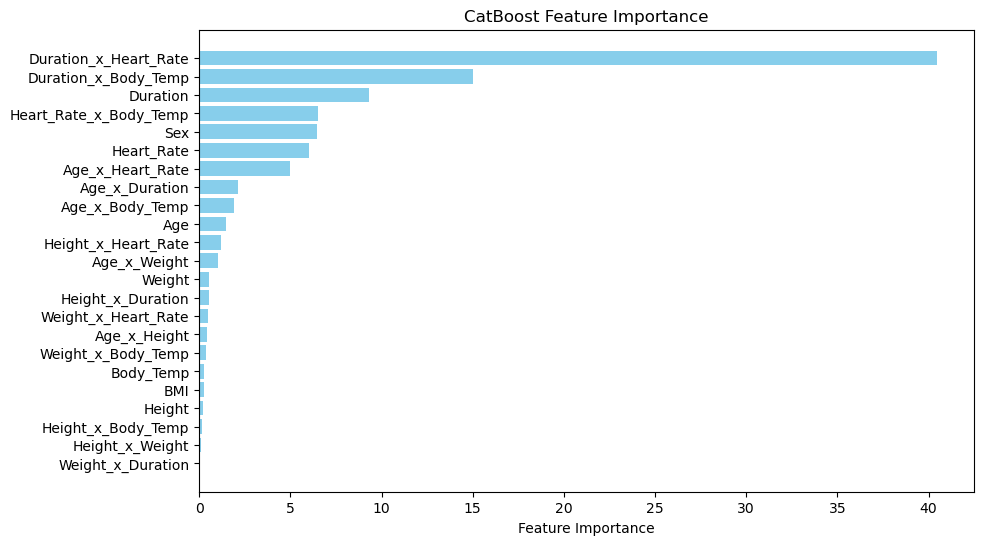

In [ ]:
# Kaggle score 0.05769, cb_prediction_3.csv, iterations 1500, learning rate 0.05, early_stopping_rounds 50, depth 16

num_indices = 600000

train_index = np.random.choice(X.index, size=num_indices, replace=False)
test_index = list(set(np.arange(len(X))) - set(train_index))


X_train, X_test = X.loc[train_index], X.loc[test_index]
y_train, y_test = y.loc[train_index], y.loc[test_index]

# Define parameters
params = {
    'iterations': 1500,
    'learning_rate': 0.05,
    'depth': 16,                 # max depth is 16
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'early_stopping_rounds': 50,
    #'subsample': ss,
    'task_type': 'GPU',
    'verbose': -1
}

# Train the model
model = CatBoostRegressor(**params)
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=0, cat_features=[0])

# Make predictions
test_pred = model.predict(X_train)

# Ensure non-negative predictions (important for RMSLE)
test_pred[test_pred < 0] = 1

print(rmse(test_pred, y_train))


# Get feature importances
feature_importances = model.get_feature_importance()

# Get feature names
feature_names = X_train.columns

# Sort feature importances and names
sorted_idx = feature_importances.argsort()
sorted_importances = feature_importances[sorted_idx]
sorted_names = feature_names[sorted_idx]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_names, sorted_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importance")
plt.show()

In [7]:
test_mod = add_feats(test, numerical_features)

test_mod.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Age_x_Height,Age_x_Weight,...,Height_x_Weight,Height_x_Duration,Height_x_Heart_Rate,Height_x_Body_Temp,Weight_x_Duration,Weight_x_Heart_Rate,Weight_x_Body_Temp,Duration_x_Heart_Rate,Duration_x_Body_Temp,Heart_Rate_x_Body_Temp
0,male,45,177,81,7,87,39.8,25.854639,7965,3645,...,14337,1239,15399,7044.6,567,7047,3223.8,609,278.6,3462.6
1,male,26,200,97,20,101,40.5,24.250000,5200,2522,...,19400,4000,20200,8100.0,1940,9797,3928.5,2020,810.0,4090.5
2,female,29,188,85,16,102,40.4,24.049344,5452,2465,...,15980,3008,19176,7595.2,1360,8670,3434.0,1632,646.4,4120.8
3,female,39,172,73,20,107,40.6,24.675500,6708,2847,...,12556,3440,18404,6983.2,1460,7811,2963.8,2140,812.0,4344.2
4,female,30,173,67,16,94,40.5,22.386314,5190,2010,...,11591,2768,16262,7006.5,1072,6298,2713.5,1504,648.0,3807.0


In [8]:
# make the submission file!

pred = model.predict(test_mod)

submission = pd.DataFrame()

submission['id'] = np.arange(len(test_mod))+750000
submission['Calories'] = np.expm1(pred)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1

submission.to_csv("cb_prediction_3.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

       id    Calories
0  750000   27.822550
1  750001  107.347116
2  750002   87.104994
3  750003  124.997950
4  750004   77.024043

count    250000.000000
mean         88.171827
std          62.262535
min           0.962659
25%          34.017781
50%          76.434855
75%         135.360932
max         293.595884
Name: Calories, dtype: float64
